## **MLP para classificação multiclasse de imagens**
**Dataset MNIST (Modified National Institute of Standards and Technology)**
- É considerado o dataset “hello world” de *computer vision*.
- Dataset de imagens de dígitos escritos manualmente
- Inputs: imagens de 28x28 pixeis
- Output: classe a representar o dígito (10 classes, dígitos 0-9)
- 70k imagens das quais 60k são para treino e 10k para teste
- 2 atributos: o id da imagem e o respetivo label   

Vamos utilizar uma rede neuronal para classificação do dígito em cada imagem de 28x28.

## Imports

In [87]:
import torch
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import matplotlib.pyplot as plt

In [88]:
# a divisão de treino e validação depende da aleatoriedade
# devemos sempre que possível colocar seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

PATH = "./"
PATH_TRAIN = 'mnist_train.csv'
PATH_TEST = 'mnist_test.csv'

device = torch.device("cpu")

BATCH_SIZE = 32
EPOCHS = 40
LEARNING_RATE = 0.001

## 1. Preparar os Dados

In [89]:

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor

class CSVDataset(Dataset):
    def __init__(self, path_train, path_test, transform=None):
        df_train = pd.read_csv(path_train, header=0)
        df_test = pd.read_csv(path_test, header=0)
        
        self.x_train = df_train.values[:, 1:]
        self.y_train = df_train.values[:, 0]
        self.x_test = df_test.values[:, 1:]
        self.y_test = df_test.values[:, 0]
        
        self.x_train = self.x_train.astype('float32')
        self.x_test = self.x_test.astype('float32')
        self.y_train = self.y_train.astype('long')
        self.y_test = self.y_test.astype('long')

        if transform:
            self.x_train = transform(self.x_train)
            self.x_test = transform(self.x_test)
        

        
    def __len_train__(self):
        return len(self.x_train)

    def __len_test__(self):
        return len(self.x_test)
    
    def __getitem_train__(self, idx):
        return [self.x_train[idx], self.y_train[idx]]

    def __getitem_test__(self, idx):
        return [self.x_test[idx], self.y_test[idx]]
    
    def get_splits_flat(self):
        x_train  = torch.from_numpy(np.array(self.x_train))
        y_train  = torch.from_numpy(np.array(self.y_train))
        x_test  = torch.from_numpy(np.array(self.x_test))
        y_test  = torch.from_numpy(np.array(self.y_test))
        train = torch.utils.data.TensorDataset(x_train,y_train)
        test = torch.utils.data.TensorDataset(x_test,y_test)
        return train, test 
    
def prepare_data_flat(path_train, path_test, transform=None):
    dataset = CSVDataset(path_train, path_test, transform)
    train, test = dataset.get_splits_flat()

    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, test_dl, train_dl_all, test_dl_all


transform = transforms.Compose([
    transforms.RandomAffine(degrees=(-30,30), scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

train_dl, test_dl,  train_dl_all, test_dl_all = prepare_data_flat(PATH_TRAIN, PATH_TEST, transform=transform)

TypeError: Unexpected type <class 'numpy.ndarray'>

## 1.1 Visualizar os Dados

In [ ]:
from IPython.display import display

def visualize_data(path):
    df = pd.read_csv(path, header=0)
    display(df)
def visualize_dataset(train_dl, test_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    x, y = next(iter(train_dl))
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor batch casos test, input: {x.shape}, output: {y.shape}")
    print(y)

visualize_data(PATH_TRAIN)
visualize_dataset(train_dl, test_dl)

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59994,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59995,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Quantidade de casos de Treino:59999
Quantidade de casos de Teste:59999


TypeError: Unexpected type <class 'numpy.ndarray'>

In [ ]:
def visualize_mnist_images_flat(dl):
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    inputs = inputs.reshape(len(inputs), 1, 28, 28)
    print(inputs.shape)
    plt.figure(figsize=(8,8))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid()
        plt.imshow(inputs[i][0], cmap='gray')
    plt.show()

visualize_mnist_images_flat(train_dl)

TypeError: Unexpected type <class 'numpy.ndarray'>

## 1.2 Verificar balanceamento do dataset

-----casos_treino------
casos: 59999
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[5923 6742 5958 6131 5842 5420 5918 6265 5851 5949]
59999


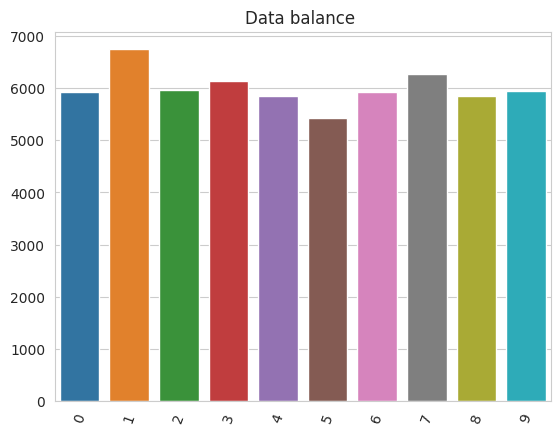

-----casos_teste------
casos: 9999
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[ 980 1135 1032 1010  982  892  958 1027  974 1009]
9999


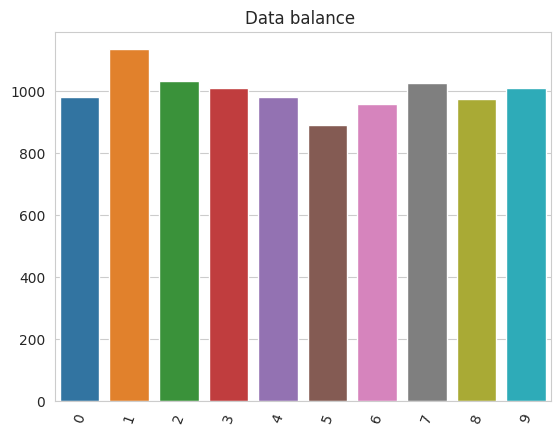

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_holdout_balance(dl):
    _, labels = next(iter(dl))
    sns.set_style('whitegrid')
    print("casos:",len(labels))
    x, y = np.unique(labels, return_counts=True)
    x=[str(n) for n in x]
    print(x)
    print(y)
    print(np.sum(y))
    grafico=sns.barplot(x=x, y=y)
    grafico.set_title('Data balance ')
    plt.xticks(rotation=70)
    plt.show() 

print("-----casos_treino------")
visualize_holdout_balance(train_dl_all)
print("-----casos_teste------")
visualize_holdout_balance(test_dl_all)

In [ ]:
#APLICAR TRANSFORMAÇÕES
# Defina as transformações a serem aplicadas aos dados
from torchvision import datasets, transforms

transform_train = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomErasing(scale=(0.02, 0.2)),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

NameError: name 'transforms' is not defined

## 2. Definir o Modelo

In [ ]:
from torchinfo import summary

class MLP(Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.hidden1 = Linear(n_inputs, 20)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.hidden2 = Linear(20, 20)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        self.hidden3 = Linear(20, 10)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Softmax()
        
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden3(X)
        X = self.act3(X)
        return X
    
model = MLP(784)
print(summary(model, input_size=(BATCH_SIZE, 784), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [32, 10]                  420
├─Linear: 1-1                            [32, 20]                  15,700
├─ReLU: 1-2                              [32, 20]                  --
├─Linear: 1-3                            [32, 10]                  210
├─Softmax: 1-4                           [32, 10]                  --
Total params: 16,330
Trainable params: 16,330
Non-trainable params: 0
Total mult-adds (M): 0.51
Input size (MB): 0.10
Forward/backward pass size (MB): 0.01
Params size (MB): 0.06
Estimated Total Size (MB): 0.17


/tmp/ipykernel_21666/3296228907.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.act3(X)


MLP(
  (hidden1): Linear(in_features=784, out_features=20, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=20, out_features=20, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=20, out_features=10, bias=True)
  (act3): Softmax(dim=None)
)

## 3. Treinar o Modelo

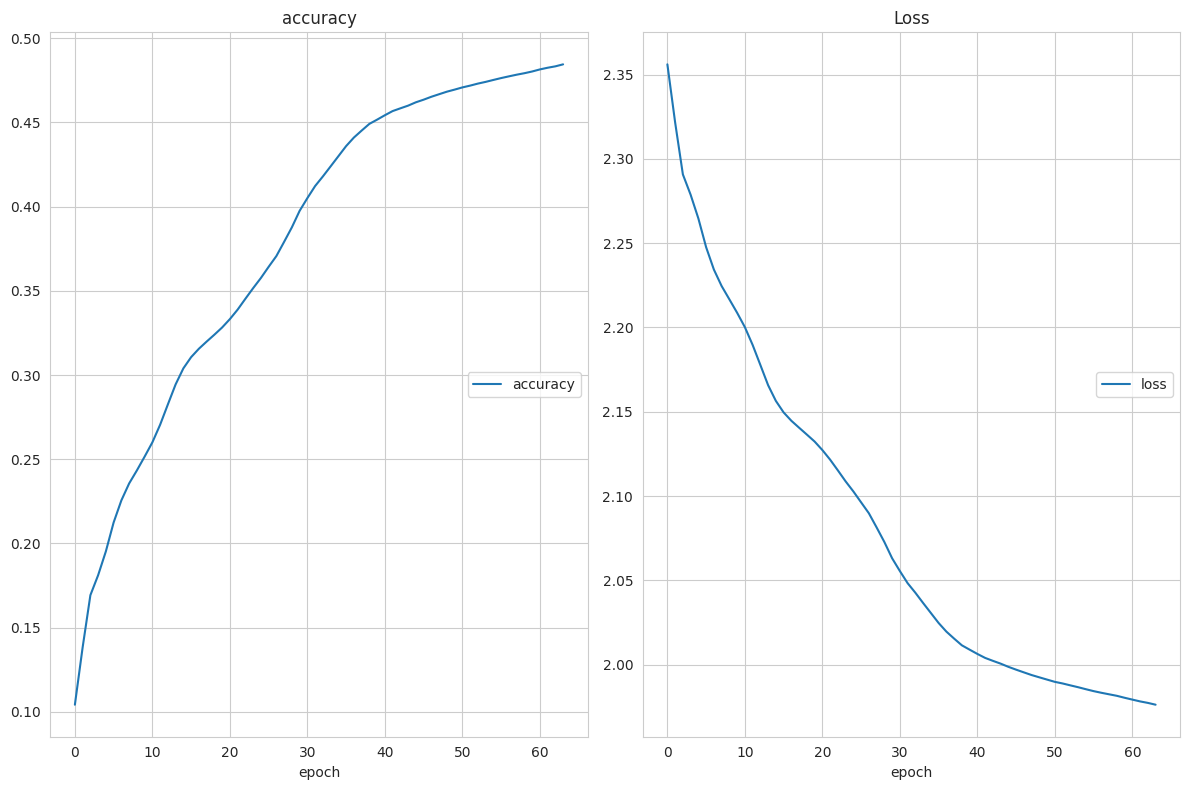

accuracy
	accuracy         	 (min:    0.104, max:    0.485, cur:    0.485)
Loss
	loss             	 (min:    1.976, max:    2.356, cur:    1.976)


In [ ]:
from torchinfo import summary
#versão com display de gráfico
from livelossplot import PlotLosses

def train_model(train_dl, model):
    liveloss = PlotLosses()
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(EPOCHS):
        logs = {}
        epoch_loss  = 0 
        epoch_acc  = 0 
        for i, (inputs, labels) in enumerate(train_dl):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = accuracy_score(labels.numpy(), np.argmax(outputs.detach().numpy(), axis=1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
        print(f'Epoch {epoch:03}: | Loss: {epoch_loss/len(train_dl):.5f} | Acc: {epoch_acc/len(train_dl):.3f}')      
        logs['loss'] = epoch_loss
        logs['accuracy'] = epoch_acc/len(train_dl)
        liveloss.update(logs)
        liveloss.send()

train_model(train_dl_all, model)

## 4. Avaliar o Modelo

/tmp/ipykernel_21666/3296228907.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.act3(X)


Accuracy: 0.487

acertou:4869 falhou:5130
              precision    recall  f1-score   support

           0       0.68      0.95      0.79       980
           1       0.00      0.00      0.00      1135
           2       0.60      0.89      0.71      1032
           3       0.55      0.92      0.69      1010
           4       0.00      0.00      0.00       982
           5       0.48      0.34      0.40       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1027
           8       0.40      0.88      0.55       974
           9       0.36      0.92      0.52      1009

    accuracy                           0.49      9999
   macro avg       0.31      0.49      0.37      9999
weighted avg       0.30      0.49      0.36      9999

[[928   0   5   8   0  13   0   0  21   5]
 [  0   0  49 317  47 102   0   5 605  10]
 [ 26   0 916  23   0   6   0   0  51  10]
 [  2   1  26 930   1  11   0   0  30   9]
 [ 10   1  30   2   0  40  

/home/purp/anaconda3/envs/deepl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/purp/anaconda3/envs/deepl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/purp/anaconda3/envs/deepl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/hom

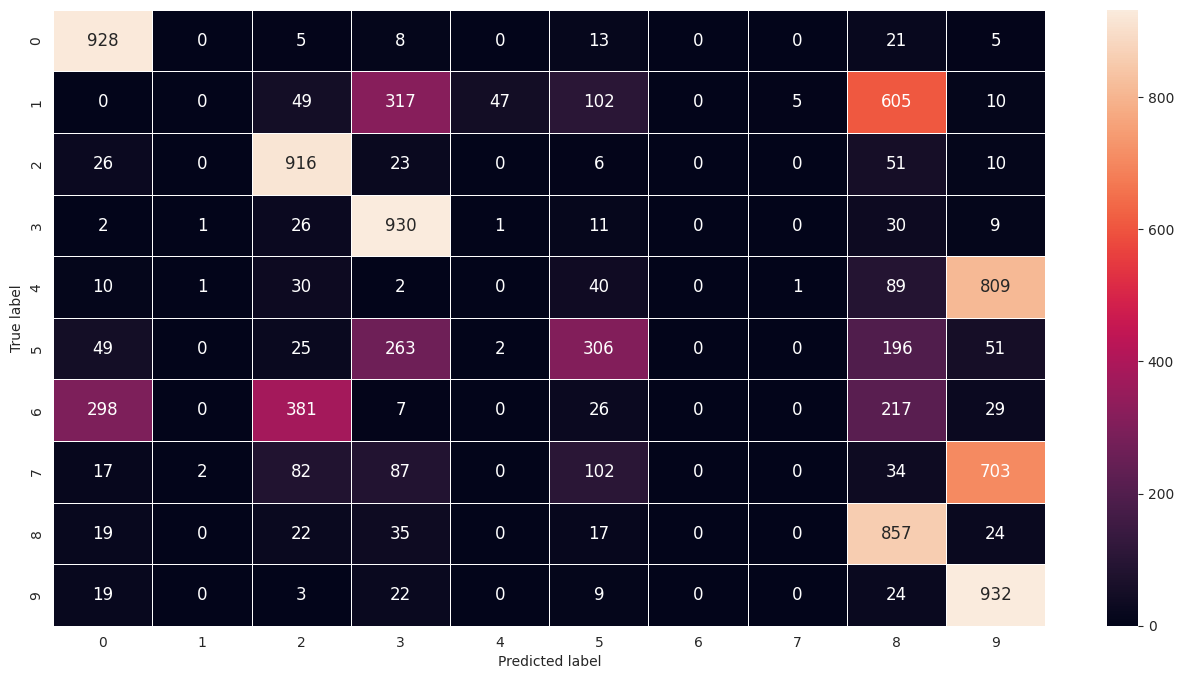

In [ ]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(test_dl):
        yprev = model(inputs)
        yprev = yprev.detach().numpy()
        actual = labels.numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
actual_values, predictions = evaluate_model(test_dl, model)

acertou=0
falhou = 0
for r,p in zip(actual_values, predictions):
    if r==p: acertou+=1  
    else: falhou+=1

acc = accuracy_score(actual_values, predictions)
print(f'Accuracy: {acc:0.3f}\n')
print(f'acertou:{acertou} falhou:{falhou}')

print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=list(cr.keys())[0:10]
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

## 5. Usar o Modelo

torch.Size([32, 784])
torch.float32
predict: 0


/tmp/ipykernel_21666/3296228907.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.act3(X)


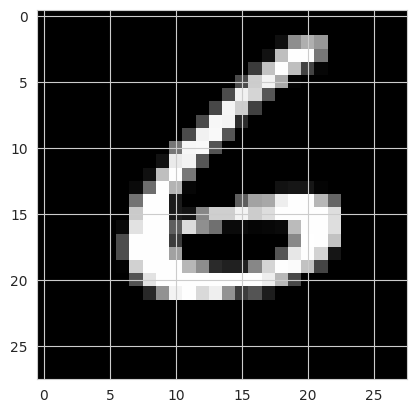

In [ ]:
def make_prediction(model, img_list, idx):
    print(img_list.shape)
    print(img_list.dtype)
    img_list = img_list.to(device)
    prediction = model(img_list).detach().numpy()[idx].argmax()
    print("predict:",prediction)
    img = img_list[idx].reshape(1,28, 28)
    plt.imshow(img[0], cmap=plt.get_cmap('gray'))
    plt.show()
    
_, (inputs, targets) = next(enumerate(test_dl))
make_prediction(model,inputs, 10)